# MSCF 46982 Market Microstructure and Algorithmic Trading
# Fall 2018 Mini 2

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", specify your name and that of your collaborator, and remove the `notimplemented` exception.



---

In [1]:
NAME: "Ze Yang"
COLLABORATOR: ""

## Volatility, Volume, Spread and Quote Profiles

Electonic trading algorithms benchmarked to arrival price face a tradoff of executing immediately with the risk of having market impact, or executing slowly with the risk of executing at a bad price as the market moves away.

To properly balance these tradeoffs, the algo must have an estimate about the shape of the intraday spread, volatility, volume and quote size profiles.

This assignment uses actual data from [NYSE Dailty TAQ](http://www.nyxdata.com/Data-Products/Daily-TAQ) to generate these estimates.

We start by opening a connection to the NYSE Daily TAQ database. The generated integer saved in `h` is a Kdb+ file handle.  It will be used for all database communication.

NOTE: The database is located on a CMU server - behind the firewall.  If you are doing this assigment from home, you will need to connect to the CMU network using the Cisco AnyConnect VPN software.

In [2]:
\c 5 100
h:0N!hopen `$":tpr-mscf-kx.tepper.cmu.edu:5000:mscf2018:mmat46982"

8i


### Part A (1 points)

Complete the `tradequery` function so that it selects trade information for a single stock across multiple days for the given time range and trade conditions.

Given a start date, end date, start time, end time, symbol and string of desired trade conditions, return a table with all the columns from the `trade` table.

In [3]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)tart (t)ime, (e)nd (t)ime, (s)ym, trade (c)ondition codes
tradequery:{[sd;ed;st;et;s;c]
    / YOUR CODE HERE
    t:select from trade where date within (sd;ed), time within (st,et), sym=s, cond in c;
    t}

In [4]:
/ pass function to database for execution
h (tradequery;2018.09.04;2018.09.04;09:30;09:35;`BAC;" ")

date       sym time                 price size stop cond ex
-----------------------------------------------------------
2018.09.04 BAC 0D09:30:08.467771000 30.9  2241 0         N 
2018.09.04 BAC 0D09:30:08.468571000 30.89 300  0         N 
2018.09.04 BAC 0D09:30:08.468765000 30.88 600  0         N 
2018.09.04 BAC 0D09:30:08.471035000 30.9  400  0         P 
2018.09.04 BAC 0D09:30:08.471071000 30.9  1000 0         N 
..


In [5]:
rnd:{x*"j"$y%x}
assert:{if[not x~y;'`$"expecting '",(-3!x),"' but found '",(-3!y),"'"]}
/ confirm all columns are included
assert[`date`sym`time`price`size`stop`cond`ex] cols h (tradequery;2018.09.01;2018.09.01;09:30;16:00;`BAC;"O")
/ confirm query only selects specified dates
assert[2] count exec distinct date from h (tradequery;2018.09.04;2018.09.05;09:30;16:00;`BAC;"O")
/ confirm only requested sym has been returned
assert[1#`BAC] exec distinct sym from h (tradequery;2018.09.04;2018.09.04;09:30;16:00;`BAC;"O")
assert[1#`TSLA] exec distinct sym from h (tradequery;2018.09.04;2018.09.04;09:30;16:00;`TSLA;"O")
/ confirm only data within the expected time range is returned
assert[1b] all within[;09:30 16:00]exec time from h (tradequery;2018.09.04;2018.09.04;09:30;16:00;`BAC;"O")
assert[1b] all within[;09:30 12:00]exec time from h (tradequery;2018.09.04;2018.09.04;09:30;12:00;`BAC;"O")
/ confirm only selected condition codes have been returned
assert[1#"O"] exec distinct cond from h (tradequery;2018.09.04;2018.09.04;09:30;16:00;`BAC;"O")
assert[" O"] exec asc distinct cond from h (tradequery;2018.09.04;2018.09.04;09:30;16:00;`BAC;" O")

### Part B (1 points)

Before computing a volatility profile, let's get some practice aggregating the data over multiple dates.

Similar to the technique as HW2, we will compute the high and low prices within each minute of each date.

Complete the `hl` function which creates two columns `h` and `l` with the max and min prices within each minute of each date.

The resulting table should have four columns (date,minute, h and l) and 390 rows - one for each minute.

In [ ]:
sym:`BAC
/ we will only use use data from the 1st through the 10th
/ while this is not a lot of trade data, you will see in the last question
/ that even loading this amount of data takes a long time and uses a few Gb of memory
sd:2018.09.01;ed:2018.09.10
st:09:30;et:16:00
t:h (tradequery;sd;ed;st;et;sym;" ")

In [7]:
hl:{[t]
 / YOUR CODE HERE
 t: select h:max price, l:min price by date,time.minute from t;
 t}

In [8]:
show highlow:hl t

date       minute| h      l     
-----------------| -------------
2018.09.04 09:30 | 30.99  30.87 
2018.09.04 09:31 | 31.03  30.975
2018.09.04 09:32 | 31     30.95 
2018.09.04 09:33 | 31.025 30.98 
2018.09.04 09:34 | 31.01  30.95 
..


In [9]:
/ confirm all columns are included
assert[`date`minute`h`l] cols highlow
/ confirm correct schema
assert["duee"] value[meta highlow]`t
/ confirm there are 390 minutes in a trading day
assert[390] count distinct key[highlow]`minute
/ confirm the high low calculations
assert[`h`l!30.95 30.93] rnd[.01] avg each flip value highlow

### Part C (1 points)

With the practice behind us, we can move on to computing an intraday volatility profile. Complete the `volatilityprofile` function which:

1. Summarizes the high and low prices within each minute of each date into columns `h` and `l`.
2. Uses the `parkinson` measure and the `h` and `l` columns to add a variance column.
3. Uses a moving average over window `w` to smooth the variance within each trading date.
4. Averages each minute's variance across dates.
5. Adds a `volatility` column with the annualized volatility.
6. Returns a table with two columns (minute and volatility) and 390 rows - one for each minute.

NOTE: You may assume the dataset will only be for a single symbol.

In [10]:
parkinson:{[h;l](1f%4f*log 2f)*r*r:log h%l}
/ given a table t (which is expected to have the columns `date`time`price)
/ generate a minutely volatility profile with smoothing (w)indow
volatilityprofile:{[w;t]
 / YOUR CODE HERE
 t:update variance:w mavg parkinson[h;l] by date from hl t;
 t:select volatility: sqrt 252*6.5*60*avg variance by minute from t;
 t}

In [11]:
tab2df:{r:.p.import[`pandas; `:DataFrame; x][@; cols x];$[count k:keys x; r[`:set_index]k; r]}
/ build a volatility profile
show vp:volatilityprofile[5] t
.p.set[`vp] tab2df vp

minute| volatility
------| ----------
09:30 | 0.6416767 
09:31 | 0.5089212 
09:32 | 0.5114596 
09:33 | 0.4675085 
09:34 | 0.444331  
..


In [12]:
/ confirm all columns are included
assert[`minute`volatility] cols vp
/ confirm the table schema is correct
assert["uf"] value[meta vp]`t
/ confirm there are 390 minutes in a trading day
assert[390] count distinct key[vp]`minute
/ confirm the computed volume profile calculations
assert[0.1294] rnd[1e-4] avg value[vp]`volatility

"p)import numpy as np"
"p)import pandas as pd"
"p)import matplotlib.pyplot as plt"
"p)vp.index = pd.to_timedelta(vp.index,unit='m')"
"p)vp.plot(title='volatility profile',figsize=(15,5))"
"p)plt.show()"


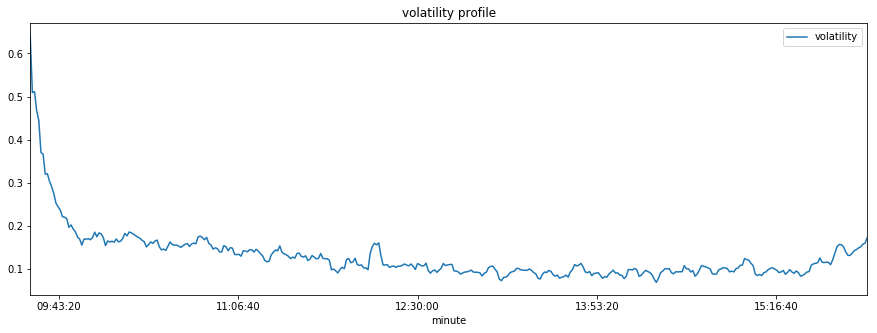

In [13]:
/%python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
vp.index = pd.to_timedelta(vp.index,unit='m')
vp.plot(title='volatility profile',figsize=(15,5))
plt.show()

### Part D (1 points)

Using the trading data complete the function `volumeprofile` which:

1. Aggregates the volume (size column) within each minute of each date.
2. Uses a moving average over window `w` to smooth the volume within each trading date.
3. To make the values comparable across stocks and days with corporate actions, convert the volumes into percentages of the total daily volume: ie, divide each minutes volume by the total volume for that date.
4. Averages each minute's percentages across dates.
5. Returns a table with two columns (minute and percent) and 390 rows - one for each minute.

NOTE: You may assume the dataset will only be for a single symbol.

In [81]:
/ given a table t (which is expected to have the columns `date`time`size)
/ generate a minutely volume profile with smoothing (w)indow
volumeprofile:{[w;t]
 / YOUR CODE HERE
 t:select volume:sum size by date, time.minute from t;
 t:update volume: w mavg volume by date from t;
 t:update dv:sum volume by date from t;
 t:select percent:avg volume%dv by minute from t;
 t}

In [72]:
/ build a volume profile
.p.set[`v] tab2df v:volumeprofile[5] t
show v

date       minute| volume dv      
-----------------| ---------------
2018.09.04 09:30 | 203449 27117619
2018.09.04 09:31 | 367622 27117619
2018.09.04 09:32 | 309632 27117619
2018.09.04 09:33 | 232497 27117619
2018.09.04 09:34 | 179526 27117619
..


In [83]:
/ confirm all columns are included
assert[`minute`percent] cols v
/ confirm the table schema is correct
assert["uf"] value[meta v]`t
/ confirm there are 390 minutes in a day
assert[390] count distinct key[v]`minute
/ confirm the computed volume profile calculations
assert[1f] rnd[.01] sum value[v]`percent

"p)import numpy as np"
"p)import pandas as pd"
"p)import matplotlib.pyplot as plt"
"p)v.index = pd.to_timedelta(v.index,unit='m')"
"p)v.plot(title='volume profile',figsize=(15,5))"
"p)plt.show()"


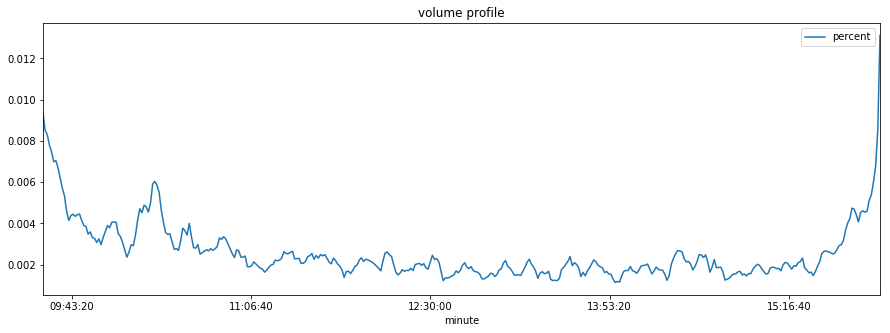

In [84]:
/%python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
v.index = pd.to_timedelta(v.index,unit='m')
v.plot(title='volume profile',figsize=(15,5))
plt.show()

### Part E (1 points)

Again, using the trade data, we can compute the implicit spread with Roll's formula.  A variant of Roll's formula has been provided that computes a percentage spread so that the values can be compared across securities and days with corporate actions.

Complete the `rspreadprofile` function which:
1. Uses Roll's percent spread formula to compute the implicit percent spread within each minute of each date.
2. Uses a moving average over window `w` to smooth the spread within each trading date.
3. Averages each minute's spread across dates.
4. Returns a table with two columns (minute and spread) and 390 rows - one for each minute.

NOTE: You may assume the dataset will only be for a single symbol.

In [18]:
/ computes the roll implicit spread as a percentage of the trade price
rollpct:{200f*sqrt neg x scov prev x:-1f+x%prev x}
/ given a table t (which is expected to have the columns `date`time`price)
/ generate a minutely spread profile with smoothing (w)indow
rspreadprofile:{[w;t]
 / YOUR CODE HERE
 t: select spread:rollpct price by date, time.minute from t;
 t: update spread:w mavg spread by date from t;
 t: select spread:avg spread by minute from t;
 t}

In [19]:
/ build a roll spread profile
.p.set[`rp] tab2df rp:rspreadprofile[5] t
show rp

minute| spread    
------| ----------
09:30 | 0.01752109
09:31 | 0.01480374
09:32 | 0.01348129
09:33 | 0.01309192
09:34 | 0.01283061
..


In [20]:
/ confirm all columns are included
assert[`minute`spread] cols rp
/ confirm the table schema is correct
assert["uf"] value[meta rp]`t
/ confirm there are 390  minutes in a day
assert[390] count distinct key[rp]`minute
/ confirm the computed spread profile calculations
assert[0.01052] rnd[1e-6] avg value[rp]`spread

"p)rp.index = pd.to_timedelta(rp.index,unit='m')"
"p)rp.plot(title='roll percent spread profile',figsize=(15,5))"
"p)plt.show()"


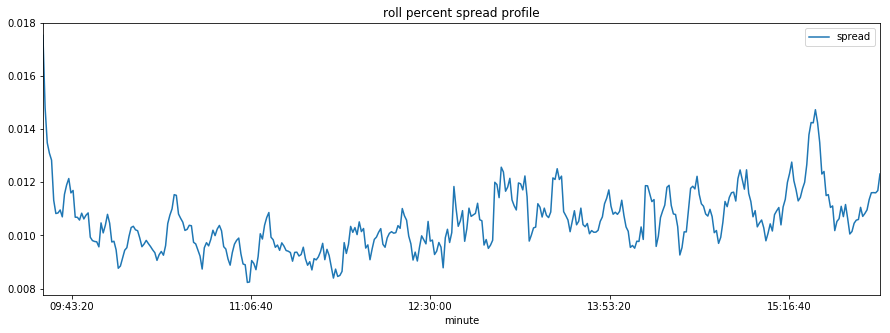

In [21]:
/%python
rp.index = pd.to_timedelta(rp.index,unit='m')
rp.plot(title='roll percent spread profile',figsize=(15,5))
plt.show()

### Part F (1 points)

Roll's spread assumes the distribution of price changes are stationary.  This would indicate that using daily data should generate a similar spread calculation as our minutely calculation. Using the `daily` table, we can generate a spread calculation for the month of September.

Complete the `dailyquery` function so that it selects daily information for a list of stocks for the given date range.

Given a start date, end date and list of symbols, return a table with the date, sym and close columns.

Hint: use the `in` operator to filter the table for multiple symbols

In [22]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)yms
dailyquery:{[sd;ed;s]
 / YOUR CODE HERE
 t:select from daily where date within (sd;ed), sym in s;
 t}

In [23]:
/ pass function to database for execution
h (dailyquery;2018.09.04;2018.09.30;`BAC`MS)

date       sym open  high  low   close price        size    
------------------------------------------------------------
2018.09.04 BAC 31    31.18 30.77 31.14 1.486993e+09 47887170
2018.09.04 MS  48.95 48.95 48.18 48.65 4.775063e+08 9826528 
2018.09.05 BAC 31.1  31.24 30.97 31.11 1.697349e+09 54551263
2018.09.05 MS  48.6  49.05 48.5  48.79 3.251869e+08 6672373 
2018.09.06 BAC 30.99 31.24 30.73 30.8  1.41743e+09  45895886
..


In [24]:
/ confirm all columns are included
assert[1b] all `date`close in cols h (dailyquery;2018.09.04;2018.09.04;`BAC)
/ confirm query only selects specified dates
assert[2018.09.04 2018.09.25] (min;max)@\:exec date from h (dailyquery;2018.09.04;2018.09.25;`BAC)
assert[2018.09.12 2018.09.14] (min;max)@\:exec date from h (dailyquery;2018.09.12;2018.09.15;`BAC)
/ confirm only requested syms have been returned
assert[1#`BAC] exec distinct sym from h (dailyquery;2018.09.04;2018.09.25;`BAC)
assert[`GOOG`TSLA] exec distinct sym from h (dailyquery;2018.09.04;2018.09.25;`TSLA`GOOG)

### Part G (1 points)

We can now write a function to compute Roll's implicit percent spread for each sym over the dates in the table.

The function should return a table with two columns (sym and spread).

Complete the `symroll` function so that it computes Roll's implicit percent spread for each sym over all dates in the provided (t)able.

If written correctly, you will notice that BAC produces a null spread.  What went wrong with the calculation?  What can be done to fix this problem?

In [25]:
/ (t)able with `close and `sym columns
symroll:{[t]
 / YOUR CODE HERE
 t: select spread:rollpct close by sym from t;
 t}

In [26]:
show sprd:symroll h (dailyquery;2018.09.04;2018.09.30;`BAC`TSLA`GOOG)

sym | spread  
----| --------
BAC |         
GOOG| 0.930028
TSLA| 5.094085


In [27]:
/ confirm all columns are included
assert[1b] all `sym`spread in cols sprd
/ confirm the table schema is correct
assert["sf"] value[meta sprd]`t
/ confirm the numbers are accurate
assert[3.01] rnd[.01] avg exec spread from sprd
/ confirm `BAC has a null spread
assert[0n] sprd[`BAC;`spread]

In [28]:
v:h (dailyquery;2018.09.04;2018.09.30;`BAC`TSLA`GOOG)
v:select from v where sym=`BAC
x scov prev x:-1f+x%prev x:v[`close]

2.750102e-05


- The results above suggests that BAC produces a null spread due to a positive serial covariance of price changes of `BAC`.
- This is one disadvantage of Roll's formula, so probably we want to look at some alternative measures/estimators of the spread.

### Part H (1 points)

We now introduce the quote sizes into our analysis.

Complete the `nbboquery` function so that it selects nbbo information for a single stock across multiple days.

Given a start date, end date, start time, end time and symbol, return a table with all of the columns from the `quote` table.

In [40]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)tart (t)ime;(e)nd (t)ime, (s)ym
nbboquery:{[sd;ed;st;et;s]
 / YOUR CODE HERE
 t:select from nbbo where sym=s, date within (sd;ed), time within (st;et);
 t}

In [41]:
/ pass function to database for execution
h (nbboquery;2018.09.04;2018.09.04;09:30;09:35;`BAC)

date       sym time                 bid   bsize ask  asize
----------------------------------------------------------
2018.09.04 BAC 0D09:30:00.123583000 30.85 78    30.9 32   
2018.09.04 BAC 0D09:30:00.160396000 30.85 78    30.9 26   
2018.09.04 BAC 0D09:30:00.160405000 30.85 78    30.9 20   
2018.09.04 BAC 0D09:30:00.160460000 30.85 78    30.9 14   
2018.09.04 BAC 0D09:30:00.160516000 30.85 78    30.9 8    
..


In [42]:
/ confirm all columns are included
assert[`date`sym`time`bid`bsize`ask`asize] cols h (nbboquery;2018.09.01;2018.09.01;09:30;09:35;`BAC)
/ confirm query only selects specified dates
assert[2] count exec distinct date from h (nbboquery;2018.09.04;2018.09.05;09:30;09:35;`BAC)
/ confirm only requested sym has been returned
assert[1#`BAC] exec distinct sym from h (nbboquery;2018.09.04;2018.09.04;09:30;09:35;`BAC)
assert[1#`TSLA] exec distinct sym from h (nbboquery;2018.04.01;2018.09.04;09:30;09:35;`TSLA)
/ confirm only data within the expected time range is returned
assert[1b] all within[;09:30 09:35]exec time from h (nbboquery;2018.09.04;2018.09.04;09:30;09:35;`BAC)
assert[1b] all within[;09:30 09:40]exec time from h (nbboquery;2018.09.04;2018.09.04;09:30;09:40;`BAC)

### Part I (1 points)

Using the nbbo data, we would like to see how the average quote size changes over the course of the trading day.

Complete the `quoteprofile` function which:

1. Adds a duration column which computes the time difference between the quote and the previous quote within each date.
2. Computes the duration weighted average `bid` and `ask` notional (again, for comparability across stocks and dates with corporate actions) within each minute of each date
3. Uses a moving average over window `w` to smooth the quoted notionals (both `bid` and `ask`) within each trading date.
4. Averages each minute's spread across dates.
5. Returns a table with three columns (minute, bid and ask) and 390 rows - one for each minute.

NOTE: You may assume the dataset will only be for a single symbol.

NOTE: Since you will be using the previous quote for each duration, the first quote in each minute will not be available. 

In [43]:
/ pass function to database for execution
n:h (nbboquery;sd;ed;st;et;sym)

In [33]:
n

date       sym time                 bid   bsize ask   asize
-----------------------------------------------------------
2018.09.04 BAC 0D09:30:00.005611000 30.43 48    31.3  48   
2018.09.04 BAC 0D09:30:00.022188000 30.72 3     30.9  8    
2018.09.04 BAC 0D09:30:00.123583000 30.85 42    30.9  8    
2018.09.04 BAC 0D09:30:00.160396000 29.61 2     31.02 1    
2018.09.04 BAC 0D09:30:00.160405000 29.61 1     32.14 1    
..


In [52]:
/ given a table n (which is expected to have the columns `date`time`asize`bsize)
/ generate a minutely quote profile with smoothing (w)indow
quoteprofile:{[w;n]
 / YOUR CODE HERE
 n: update duration: time-prev time by date from n;
 n: select ask: "e"$duration wavg prev ask*asize, bid: "e"$duration wavg prev bid*bsize by date, time.minute from n;
 n: update ask: w mavg ask, bid: w mavg bid by date from n;
 n: select avg bid, avg ask by minute from n;
 n}

In [53]:
/ build a roll spread profile
show qp:quoteprofile[5] n
.p.set[`qp] tab2df qp

minute| bid      ask     
------| -----------------
09:30 | 1482.557 1594.177
09:31 | 2170.366 3056.734
09:32 | 2637.959 4260.076
09:33 | 2996.165 4394.345
09:34 | 3339.459 4289.38 
..


In [54]:
/ confirm all columns are included
assert[`minute`bid`ask] cols qp
/ confirm there are 390 minutes in a day
assert[390] count distinct key[qp]`minute
/ confirm the computed quote profile calculations
assert[26221.67 22573.03] rnd[.01] avg each value[qp]`ask`bid

"p)qp.index = pd.to_timedelta(qp.index,unit='m')"
"p)qp.plot(title='quote size profile',figsize=(15,5))"
"p)plt.show()"


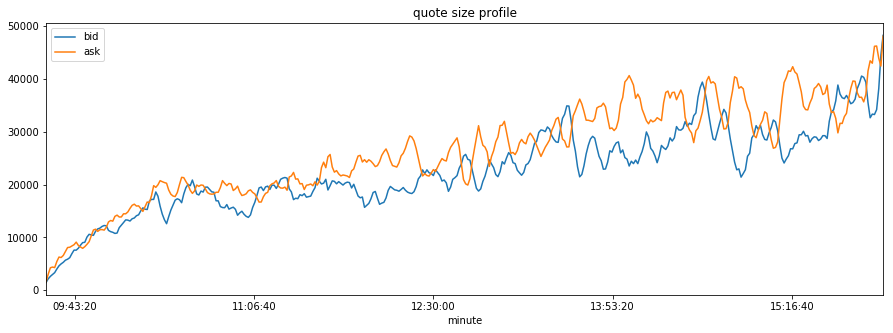

In [55]:
/%python
qp.index = pd.to_timedelta(qp.index,unit='m')
qp.plot(title='quote size profile',figsize=(15,5))
plt.show()

### Part J (1 points)

Roll's implicit spread gave us a profile that would be expected from a market maker.  Let's see what the spread looks like from a market taker.  Using the nbbo data, we can see how the average quote spread changes over the course of the trading day.

Complete the `nspreadprofile` function which:

1. Adds a duration column which computes the time difference between the quote and the previous quote within each date.
1. Computes the time weighted average percent spread (100*spread/mid) within each minute of each date
2. Uses a moving average over window `w` to smooth the percent spread within each trading date.
2. Averages each minute's percent spread across dates.

The resulting table should have two columns (minute and spread) and 390 rows - one for each minute.

NOTE: You may assume the dataset will only be for a single symbol.

NOTE: Since you will be using the previous spread for each duration, the first spread in each minute will not be available. 

In [67]:
/ given a table n (which is expected to have the columns `date`time`asize`bsize)
/ generate a minutely volume profile with smoothing (w)indow
nspreadprofile:{[w;n]
 / YOUR CODE HERE
 n: update duration: time-prev time by date from n;
 n: select twasprd: "e"$duration wavg 200*(ask-bid)%(ask+bid) by date, time.minute from n;
 n: update twasprd: w mavg twasprd by date from n;
 n: select spread:avg twasprd by minute from n;
 n}

In [68]:
/ build a spread profile
show nsp:nspreadprofile[5] n
.p.set[`nsp] tab2df nsp

minute| spread    
------| ----------
09:30 | 0.05840586
09:31 | 0.04550641
09:32 | 0.04101866
09:33 | 0.03881556
09:34 | 0.03749226
..


In [69]:
/ confirm all columns are included
assert[`minute`spread] cols nsp
/ confirm the table schema is correct
assert["uf"] value[meta nsp]`t
/ confirm there are 390 minutes in a day
assert[390] count distinct key[nsp]`minute
/ confrim the computed volume profile calculations
assert[0.0324] rnd[1e-4] avg value[nsp]`spread

"p)nsp.index = pd.to_timedelta(nsp.index,unit='m')"
"p)nsp.plot(title='nbbo spread profile',figsize=(15,5))"
"p)plt.show()"


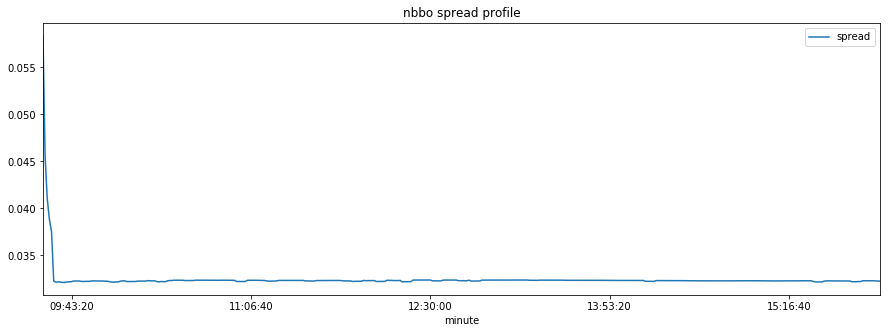

In [70]:
/%python
nsp.index = pd.to_timedelta(nsp.index,unit='m')
nsp.plot(title='nbbo spread profile',figsize=(15,5))
plt.show()